In [1]:
import pandas as pd #pandas for data wrangling
import numpy as np #numpy for mathematical computations
import pyodbc
import seaborn as sns #seaborn for visualizations
import matplotlib.pyplot as plt #matplotlib for visualizations
import scipy
from scipy.stats import spearmanr 
from scipy.stats import chi2_contingency
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.metrics import f1_score,accuracy_score, roc_auc_score, ConfusionMatrixDisplay, confusion_matrix, precision_score, recall_score, classification_report
from sklearn.pipeline import FeatureUnion, make_pipeline
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from lifelines import KaplanMeierFitter, CoxPHFitter 
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.width', 500)             
pd.set_option('display.expand_frame_repr', False)

C:\Users\TITILAYO\AppData\Roaming\Python\Python311\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


# Data

Data Description
Demographics
Location
Population
Services
Status
Each table is described below.
CustomerID: A unique ID that identifies each customer.

Gender: The customer’s gender: Male, Female

Age: The customer’s current age, in years, at the time the fiscal quarter ended.

Senior Citizen: Indicates if the customer is 65 or older: Yes, No

Married: Indicates if the customer is married: Yes, No

Dependents: Indicates if the customer lives with any dependents: Yes, No. Dependents could be children, parents, grandparents, etc.

Number of Dependents: Indicates the number of dependents that live with the customer.

Country: The country of the customer’s primary residence.

State: The state of the customer’s primary residence.

City: The city of the customer’s primary residence.

Zip Code: The zip code of the customer’s primary residence.

Latitude: The latitude of the customer’s primary residence.

Longitude: The longitude of the customer’s primary residence.

Population: A current population estimate for the entire Zip Code area.

Referred a Friend: Indicates if the customer has ever referred a friend or family member to this company: Yes, No

Number of Referrals: Indicates the number of referrals to date that the customer has made.

Tenure in Months: Indicates the total amount of months that the customer has been with the company by the end of the quarter specified above.

Offer: Identifies the last marketing offer that the customer accepted, if applicable. Values include None, Offer A, Offer B, Offer C, Offer D, and Offer E.

Phone Service: Indicates if the customer subscribes to home phone service with the company: Yes, No

Avg Monthly Long Distance Charges: Indicates the customer’s average long distance charges, calculated to the end of the quarter specified above.

Multiple Lines: Indicates if the customer subscribes to multiple telephone lines with the company: Yes, No

Internet Service: Indicates if the customer subscribes to Internet service with the company: No, DSL, Fiber Optic, Cable.

Avg Monthly GB Download: Indicates the customer’s average download volume in gigabytes, calculated to the end of the quarter specified above.

Online Security: Indicates if the customer subscribes to an additional online security service provided by the company: Yes, No

Online Backup: Indicates if the customer subscribes to an additional online backup service provided by the company: Yes, No

Device Protection Plan: Indicates if the customer subscribes to an additional device protection plan for their Internet equipment provided by the company: Yes, No

Premium Tech Support: Indicates if the customer subscribes to an additional technical support plan from the company with reduced wait times: Yes, No

Streaming TV: Indicates if the customer uses their Internet service to stream television programing from a third party provider: Yes, No. The company does not charge an additional fee for this service.

Streaming Movies: Indicates if the customer uses their Internet service to stream movies from a third party provider: Yes, No. The company does not charge an additional fee for this service.

Streaming Music: Indicates if the customer uses their Internet service to stream music from a third party provider: Yes, No. The company does not charge an additional fee for this service.

Unlimited Data: Indicates if the customer has paid an additional monthly fee to have unlimited data downloads/uploads: Yes, No

Contract: Indicates the customer’s current contract type: Month-to-Month, One Year, Two Year.

Paperless Billing: Indicates if the customer has chosen paperless billing: Yes, No

Payment Method: Indicates how the customer pays their bill: Bank Withdrawal, Credit Card, Mailed Check

Monthly Charge: Indicates the customer’s current total monthly charge for all their services from the company.

Total Charges: Indicates the customer’s total charges, calculated to the end of the quarter specified above.

Total Refunds: Indicates the customer’s total refunds, calculated to the end of the quarter specified above.

Total Extra Data Charges: Indicates the customer’s total charges for extra data downloads above those specified in their plan, by the end of the quarter specified above.

Total Long Distance Charges: Indicates the customer’s total charges for long distance above those specified in their plan, by the end of the quarter specified above.

Satisfaction Score: A customer’s overall satisfaction rating of the company from 1 (Very Unsatisfied) to 5 (Very Satisfied).

Customer Status: Indicates the status of the customer at the end of the quarter: Churned, Stayed, or Joined

Churn Label: Yes = the customer left the company this quarter. No = the customer remained with the company. Directly related to Churn Value.

Churn Value: 1 = the customer left the company this quarter. 0 = the customer remained with the company. Directly related to Churn Label.

Churn Score: A value from 0-100 that is calculated using the predictive tool IBM SPSS Modeler. The model incorporates multiple factors known to cause churn. The higher the score, the more likely the customer will churn.

CLTV: Customer Lifetime Value. A predicted CLTV is calculated using corporate formulas and existing data. The higher the value, the more valuable the customer. High value customers should be monitored for churn.

Churn Category: A high-level category for the customer’s reason for churning: Attitude, Competitor, Dissatisfaction, Other, Price. When they leave the company, all customers are asked about their reasons for leaving. Directly related to Churn Reason.

Churn Reason: A customer’s specific reason for leaving the company. Directly related to Churn Category.

In [2]:

conn = pyodbc.connect('DRIVER={SQL Server};'
    'SERVER=TWELVE\\MSSQLSERVER01;'
    'DATABASE=TelcoCustomerChurnDB2;'
    'Trusted_Connection=yes;'
)
sql_for_df = """SELECT *
FROM [dbo].[FactCustomer] AS fact
RIGHT JOIN [dbo].[DimCustomer] AS customer
ON customer.CustomerID = fact.CustomerID
RIGHT JOIN [dbo].[DimLocation] AS loca
ON fact.LocationID = loca.LocationID
RIGHT JOIN [dbo].[DimService] AS serv
ON serv.ServiceID = fact.ServiceID
RIGHT JOIN [dbo].[DimStatus] AS stat
ON stat.StatusID = fact.StatusID
"""

df = pd.read_sql(sql_for_df, conn)

In [3]:
df.head()

,FactID,CustomerID,LocationID,ServiceID,StatusID,SatisfactionScore,ChurnLabel,CLTV,MonthlyCharge,TotalCharges,TotalRefunds,TotalExtraDataCharges,TotalLongDistanceCharges,TotalRevenue,AvgMonthlyGBDownload,AvgMonthlyLongDistanceCharges,CustomerID,Gender,Age,Under30,SeniorCitizen,Married,Dependents,NumberOfDependents,LocationID,Country,State,City,ZipCode,Latitude,Longitude,Population,ServiceID,ReferredAFriend,NumberOfReferrals,TenureInMonths,Offer,PhoneService,AvgMonthlyLongDistanceCharges,MultipleLines,InternetService,InternetType,AvgMonthlyGBDownload,OnlineSecurity,OnlineBackup,DeviceProtectionPlan,PremiumTechSupport,StreamingTV,StreamingMovies,StreamingMusic,UnlimitedData,Contract,PaperlessBilling,PaymentMethod,MonthlyCharge,TotalCharges,TotalRefunds,TotalExtraDataCharges,TotalLongDistanceCharges,TotalRevenue,CLTV,StatusID,SatisfactionScore,CustomerStatus,ChurnLabel,ChurnValue,ChurnScore,ChurnCategory,ChurnReason
0,3183,2988-QRAJY,ARITSJ9269,EBQRARPRX3595,AAEDXJ7271,3,No,5798,110.05,7430.75,23.16,0.0,393.99,7801.58,73,5.71,2988-QRAJY,Male,27,Yes,No,No,No,0,ARITSJ9269,United States,California,Santa Rosa,95403,38.488431,-122.752839,40270,EBQRARPRX3595,No,0,69,Offer A,Yes,5.71,Yes,Yes,Fiber Optic,73,Yes,Yes,Yes,No,Yes,Yes,Yes,Yes,Two Year,Yes,Credit Card,110.05,7430.75,23.16,0.0,393.99,7801.58,5798,AAEDXJ7271,3,Stayed,No,0,30,None,None
1,3454,2919-HBCJO,DHYDIP7892,QBJOZKEOS7147,AAGVIW5278,1,Yes,4580,76.65,333.60,0.00,0.0,96.36,429.96,17,24.09,2919-HBCJO,Female,36,No,No,No,No,0,DHYDIP7892,United States,California,Downieville,95936,39.578792,-120.780786,404,QBJOZKEOS7147,No,0,4,None,Yes,24.09,No,Yes,Fiber Optic,17,No,Yes,No,No,No,No,No,Yes,Month-to-Month,Yes,Bank Withdrawal,76.65,333.60,0.00,0.0,96.36,429.96,4580,AAGVIW5278,1,Churned,Yes,1,90,Other,Moved
2,6176,6670-MFRPK,ZQJQWP3115,CRZHCDMWV5355,AAIFDJ8638,4,No,4072,79.20,5420.65,0.00,0.0,1487.64,6908.29,17,21.56,6670-MFRPK,Male,53,No,No,Yes,Yes,1,ZQJQWP3115,United States,California,Coalinga,93210,36.186867,-120.387793,18036,CRZHCDMWV5355,Yes,5,69,Offer A,Yes,21.56,Yes,Yes,Fiber Optic,17,No,No,Yes,No,No,No,No,Yes,Two Year,Yes,Credit Card,79.20,5420.65,0.00,0.0,1487.64,6908.29,4072,AAIFDJ8638,4,Stayed,No,0,63,None,None
3,201,8519-IMDHU,IYPGCT3765,DGIECJYQD7826,AAIKCR2516,1,Yes,4981,85.60,1345.55,0.00,0.0,678.75,2024.30,22,45.25,8519-IMDHU,Male,74,No,Yes,Yes,No,0,IYPGCT3765,United States,California,Alderpoint,95511,40.166028,-123.584144,261,DGIECJYQD7826,Yes,1,15,None,Yes,45.25,Yes,Yes,Cable,22,No,No,No,No,No,Yes,No,Yes,Month-to-Month,Yes,Bank Withdrawal,85.60,1345.55,0.00,0.0,678.75,2024.30,4981,AAIKCR2516,1,Churned,Yes,1,83,Competitor,Competitor had better devices
4,1881,0486-LGCCH,JTITTM2455,KLMHMXZHZ1496,AAQGMP6683,3,No,3372,19.65,225.75,0.00,0.0,448.36,674.11,0,40.76,0486-LGCCH,Male,48,No,No,Yes,Yes,2,JTITTM2455,United States,California,Victorville,92394,34.567058,-117.362329,12083,KLMHMXZHZ1496,Yes,2,11,Offer D,Yes,40.76,No,No,None,0,No,No,No,No,No,No,No,No,Two Year,No,Credit Card,19.65,225.75,0.00,0.0,448.36,674.11,3372,AAQGMP6683,3,Stayed,No,0,33,None,None


In [4]:
df2=pd.read_csv('C:\\Users\\TITILAYO\\Downloads\\telco_data.csv')


# Data Wrangling

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 69 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   FactID                         7043 non-null   int64  
 1   CustomerID                     7043 non-null   object 
 2   LocationID                     7043 non-null   object 
 3   ServiceID                      7043 non-null   object 
 4   StatusID                       7043 non-null   object 
 5   SatisfactionScore              7043 non-null   int64  
 6   ChurnLabel                     7043 non-null   object 
 7   CLTV                           7043 non-null   int64  
 8   MonthlyCharge                  7043 non-null   float64
 9   TotalCharges                   7043 non-null   float64
 10  TotalRefunds                   7043 non-null   float64
 11  TotalExtraDataCharges          7043 non-null   float64
 12  TotalLongDistanceCharges       7043 non-null   f

In [6]:
df.shape

(7043, 69)

In [7]:
df.duplicated().sum()


0

In [8]:
df.isnull().sum()

FactID                              0
CustomerID                          0
LocationID                          0
ServiceID                           0
StatusID                            0
SatisfactionScore                   0
ChurnLabel                          0
CLTV                                0
MonthlyCharge                       0
TotalCharges                        0
TotalRefunds                        0
TotalExtraDataCharges               0
TotalLongDistanceCharges            0
TotalRevenue                        0
AvgMonthlyGBDownload                0
AvgMonthlyLongDistanceCharges       0
CustomerID                          0
Gender                              0
Age                                 0
Under30                             0
SeniorCitizen                       0
Married                             0
Dependents                          0
NumberOfDependents                  0
LocationID                          0
Country                             0
State       

# Removal of Irrelevant Columns

In [9]:
df.columns

Index(['FactID', 'CustomerID', 'LocationID', 'ServiceID', 'StatusID', 'SatisfactionScore', 'ChurnLabel', 'CLTV', 'MonthlyCharge', 'TotalCharges', 'TotalRefunds', 'TotalExtraDataCharges', 'TotalLongDistanceCharges', 'TotalRevenue', 'AvgMonthlyGBDownload', 'AvgMonthlyLongDistanceCharges', 'CustomerID', 'Gender', 'Age', 'Under30', 'SeniorCitizen', 'Married', 'Dependents', 'NumberOfDependents', 'LocationID', 'Country', 'State', 'City', 'ZipCode', 'Latitude', 'Longitude', 'Population', 'ServiceID',
       'ReferredAFriend', 'NumberOfReferrals', 'TenureInMonths', 'Offer', 'PhoneService', 'AvgMonthlyLongDistanceCharges', 'MultipleLines', 'InternetService', 'InternetType', 'AvgMonthlyGBDownload', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtectionPlan', 'PremiumTechSupport', 'StreamingTV', 'StreamingMovies', 'StreamingMusic', 'UnlimitedData', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharge', 'TotalCharges', 'TotalRefunds', 'TotalExtraDataCharges', 'TotalLongDistanceCharges',
  

In [10]:
df_model = df.drop(['FactID', 'CustomerID', 'LocationID', 'ServiceID', 'StatusID', 'Country', 'State', 'City', 'ZipCode', 'Latitude', 
'Longitude', 'CustomerStatus', 'ChurnLabel','ChurnScore', 'ChurnCategory', 'ChurnReason'],axis=1)

In [11]:
#To identify duplicated columns
df_model = df_model.loc[:, ~df_model.columns.duplicated()]

# Display the first 10 rows and columns to limit the output size
print(df_model.iloc[:9, :9])

   SatisfactionScore  CLTV  MonthlyCharge  TotalCharges  TotalRefunds  TotalExtraDataCharges  TotalLongDistanceCharges  TotalRevenue  AvgMonthlyGBDownload
0                  3  5798         110.05       7430.75         23.16                    0.0                    393.99       7801.58                    73
1                  1  4580          76.65        333.60          0.00                    0.0                     96.36        429.96                    17
2                  4  4072          79.20       5420.65          0.00                    0.0                   1487.64       6908.29                    17
3                  1  4981          85.60       1345.55          0.00                    0.0                    678.75       2024.30                    22
4                  3  3372          19.65        225.75          0.00                    0.0                    448.36        674.11                     0
5                  4  4928          56.35       2391.15          0.00 

In [12]:
df_model.shape

(7043, 38)

In [13]:
#For unsupervised ML
data = df_model

In [14]:
df_model.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 38 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   SatisfactionScore              7043 non-null   int64  
 1   CLTV                           7043 non-null   int64  
 2   MonthlyCharge                  7043 non-null   float64
 3   TotalCharges                   7043 non-null   float64
 4   TotalRefunds                   7043 non-null   float64
 5   TotalExtraDataCharges          7043 non-null   float64
 6   TotalLongDistanceCharges       7043 non-null   float64
 7   TotalRevenue                   7043 non-null   float64
 8   AvgMonthlyGBDownload           7043 non-null   int64  
 9   AvgMonthlyLongDistanceCharges  7043 non-null   float64
 10  Gender                         7043 non-null   object 
 11  Age                            7043 non-null   int64  
 12  Under30                        7043 non-null   o

In [15]:
df_model.head()

,SatisfactionScore,CLTV,MonthlyCharge,TotalCharges,TotalRefunds,TotalExtraDataCharges,TotalLongDistanceCharges,TotalRevenue,AvgMonthlyGBDownload,AvgMonthlyLongDistanceCharges,Gender,Age,Under30,SeniorCitizen,Married,Dependents,NumberOfDependents,Population,ReferredAFriend,NumberOfReferrals,TenureInMonths,Offer,PhoneService,MultipleLines,InternetService,InternetType,OnlineSecurity,OnlineBackup,DeviceProtectionPlan,PremiumTechSupport,StreamingTV,StreamingMovies,StreamingMusic,UnlimitedData,Contract,PaperlessBilling,PaymentMethod,ChurnValue
0,3,5798,110.05,7430.75,23.16,0.0,393.99,7801.58,73,5.71,Male,27,Yes,No,No,No,0,40270,No,0,69,Offer A,Yes,Yes,Yes,Fiber Optic,Yes,Yes,Yes,No,Yes,Yes,Yes,Yes,Two Year,Yes,Credit Card,0
1,1,4580,76.65,333.60,0.00,0.0,96.36,429.96,17,24.09,Female,36,No,No,No,No,0,404,No,0,4,None,Yes,No,Yes,Fiber Optic,No,Yes,No,No,No,No,No,Yes,Month-to-Month,Yes,Bank Withdrawal,1
2,4,4072,79.20,5420.65,0.00,0.0,1487.64,6908.29,17,21.56,Male,53,No,No,Yes,Yes,1,18036,Yes,5,69,Offer A,Yes,Yes,Yes,Fiber Optic,No,No,Yes,No,No,No,No,Yes,Two Year,Yes,Credit Card,0
3,1,4981,85.60,1345.55,0.00,0.0,678.75,2024.30,22,45.25,Male,74,No,Yes,Yes,No,0,261,Yes,1,15,None,Yes,Yes,Yes,Cable,No,No,No,No,No,Yes,No,Yes,Month-to-Month,Yes,Bank Withdrawal,1
4,3,3372,19.65,225.75,0.00,0.0,448.36,674.11,0,40.76,Male,48,No,No,Yes,Yes,2,12083,Yes,2,11,Offer D,Yes,No,No,None,No,No,No,No,No,No,No,No,Two Year,No,Credit Card,0


In [17]:
categorical_columns = df_model.select_dtypes(include=['object', 'category']).columns

print(categorical_columns)

Index(['Gender', 'Under30', 'SeniorCitizen', 'Married', 'Dependents', 'ReferredAFriend', 'Offer', 'PhoneService', 'MultipleLines', 'InternetService', 'InternetType', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtectionPlan', 'PremiumTechSupport', 'StreamingTV', 'StreamingMovies', 'StreamingMusic', 'UnlimitedData', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'ChurnValue'], dtype='object')


In [18]:
len(categorical_columns)

23

In [19]:
df_model[['Gender', 'Under30', 'SeniorCitizen', 'Married', 'Dependents', 'ReferredAFriend', 'Offer', 'PhoneService', 
          'MultipleLines', 'InternetService', 'InternetType', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtectionPlan', 'PremiumTechSupport', 
          'StreamingTV',
          'StreamingMovies', 'StreamingMusic', 'UnlimitedData', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'ChurnValue']].nunique()

Gender                  2
Under30                 2
SeniorCitizen           2
Married                 2
Dependents              2
ReferredAFriend         2
Offer                   6
PhoneService            2
MultipleLines           2
InternetService         2
InternetType            4
OnlineSecurity          2
OnlineBackup            2
DeviceProtectionPlan    2
PremiumTechSupport      2
StreamingTV             2
StreamingMovies         2
StreamingMusic          2
UnlimitedData           2
Contract                3
PaperlessBilling        2
PaymentMethod           3
ChurnValue              2
dtype: int64

In [20]:
#function to encode binary categroical columns

def encode_binary_columns(df, column_name):
    """
    Encodes binary categorical columns using pd.get_dummies(), drops the first column, 
    and replaces the original column with the new binary column.
    
    Args:
    df (pd.DataFrame): The input dataframe.
    column_name (str): The name of the binary categorical column to encode.
    
    Returns:
    pd.DataFrame: DataFrame with the encoded column.
    """
    # Perform one-hot encoding and drop the first column
    dummies = pd.get_dummies(df[column_name], dtype='int',drop_first=True)
    
    # Replace the old column with the new one
    df[column_name] = dummies
    return df

def enocde_multicategorical_columns(df_model, column_name):
    """
    Encodes multi-category columns using pd.get_dummies(), drops the first column, 
    and appends the resulting dummy columns to the dataframe.
    
    Args:
    df_model (pd.DataFrame): The input dataframe.
    column_name (str): The name of the multi-category column to encode.
    
     Returns:
    pd.DataFrame: DataFrame with the encoded columns appended.
    """
    # Perform one-hot encoding and drop the first column
    dummies = pd.get_dummies(df_model[column_name], dtype='int', prefix=column_name)
    
    # Drop the original column and append the new encoded columns
    df_model = df_model.drop(column_name, axis=1)
    df_model = pd.concat([df_model, dummies], axis=1)
    
    return df_model

In [21]:
#Applying these functions accordingly (pay attention to the type of encoding wether nominal or ordinal)
categorical_columns = df_model.select_dtypes(include=['object', 'category']).columns

# Step 2: Loop over the categorical columns and encode them
for column in categorical_columns:
    unique_values = df_model[column].nunique()  # Get the number of unique categories
    
    if unique_values == 2:
        # If the column has exactly 2 unique categories, treat it as binary and encode
        df_model = encode_binary_columns(df_model, column)
    elif unique_values > 2:
        # If the column has more than 3 unique categories, treat it as multi-category and encode
        df_model = enocde_multicategorical_columns(df_model, column)

In [22]:
df_model.select_dtypes(include=['object', 'category']).columns

Index([], dtype='object')

# Building Our Unsupervised ML Model

In [23]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from kmodes.kprototypes import KPrototypes
from sklearn.preprocessing import StandardScaler

# KPrototypes Model

In [24]:
df_model.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 50 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   SatisfactionScore              7043 non-null   int64  
 1   CLTV                           7043 non-null   int64  
 2   MonthlyCharge                  7043 non-null   float64
 3   TotalCharges                   7043 non-null   float64
 4   TotalRefunds                   7043 non-null   float64
 5   TotalExtraDataCharges          7043 non-null   float64
 6   TotalLongDistanceCharges       7043 non-null   float64
 7   TotalRevenue                   7043 non-null   float64
 8   AvgMonthlyGBDownload           7043 non-null   int64  
 9   AvgMonthlyLongDistanceCharges  7043 non-null   float64
 10  Gender                         7043 non-null   int32  
 11  Age                            7043 non-null   int64  
 12  Under30                        7043 non-null   i

In [25]:
scaler = StandardScaler()

In [26]:
scaled_data = scaler.fit_transform(df_model)

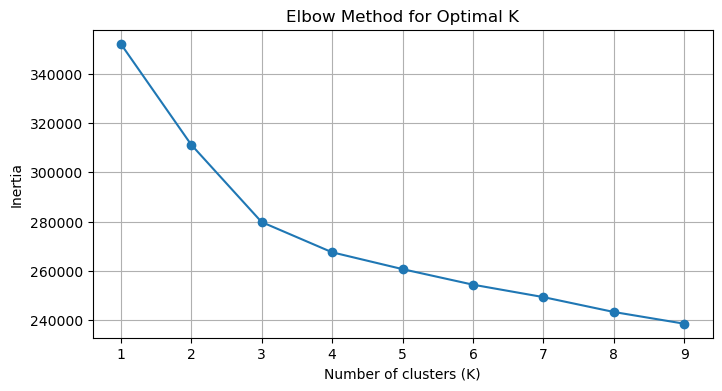

In [27]:
# Determine the optimal number of clusters (K) using the Elbow Method
inertia = []
K = range(1, 10)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_data)
    inertia.append(kmeans.inertia_)

# Plot the Elbow curve
plt.figure(figsize=(8, 4))
plt.plot(K, inertia, marker='o')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of clusters (K)')
plt.ylabel('Inertia')
plt.grid()
plt.show()

In [28]:
df_model.head()

,SatisfactionScore,CLTV,MonthlyCharge,TotalCharges,TotalRefunds,TotalExtraDataCharges,TotalLongDistanceCharges,TotalRevenue,AvgMonthlyGBDownload,AvgMonthlyLongDistanceCharges,Gender,Age,Under30,SeniorCitizen,Married,Dependents,NumberOfDependents,Population,ReferredAFriend,NumberOfReferrals,TenureInMonths,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtectionPlan,PremiumTechSupport,StreamingTV,StreamingMovies,StreamingMusic,UnlimitedData,PaperlessBilling,ChurnValue,Offer_None,Offer_Offer A,Offer_Offer B,Offer_Offer C,Offer_Offer D,Offer_Offer E,InternetType_Cable,InternetType_DSL,InternetType_Fiber Optic,InternetType_None,Contract_Month-to-Month,Contract_One Year,Contract_Two Year,PaymentMethod_Bank Withdrawal,PaymentMethod_Credit Card,PaymentMethod_Mailed Check
0,3,5798,110.05,7430.75,23.16,0.0,393.99,7801.58,73,5.71,1,27,1,0,0,0,0,40270,0,0,69,1,1,1,1,1,1,0,1,1,1,1,1,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,1,0
1,1,4580,76.65,333.60,0.00,0.0,96.36,429.96,17,24.09,0,36,0,0,0,0,0,404,0,0,4,1,0,1,0,1,0,0,0,0,0,1,1,1,1,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0
2,4,4072,79.20,5420.65,0.00,0.0,1487.64,6908.29,17,21.56,1,53,0,0,1,1,1,18036,1,5,69,1,1,1,0,0,1,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,1,0
3,1,4981,85.60,1345.55,0.00,0.0,678.75,2024.30,22,45.25,1,74,0,1,1,0,0,261,1,1,15,1,1,1,0,0,0,0,0,1,0,1,1,1,1,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0
4,3,3372,19.65,225.75,0.00,0.0,448.36,674.11,0,40.76,1,48,0,0,1,1,2,12083,1,2,11,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,1,0


In [29]:
array = df_model.values

#Apply model
kproto = KPrototypes(n_clusters=3, random_state=42, n_init=5)
df_model['Kmodes_cluster'] = kproto.fit_predict(array, categorical=[0,10,11,12,13,14,15,18,21,23,24,26,27,28,29,30,31,32,33,34,44
                                                                    ,45,46,47,48,49])

In [30]:
# Use PCA for Visualization (if you have continuous variables)
# You may want to apply PCA to your continuous variables only
scaler = StandardScaler()
pca_data = scaler.fit_transform(df_model.select_dtypes(include=[np.number]))
pca = PCA(n_components=2)
pca_result = pca.fit_transform(pca_data)

In [31]:
# Create a DataFrame for PCA results
pca_df = pd.DataFrame(data=pca_result, columns=['PCA1', 'PCA2'])
pca_df['Kmodes_cluster'] = df_model['Kmodes_cluster']

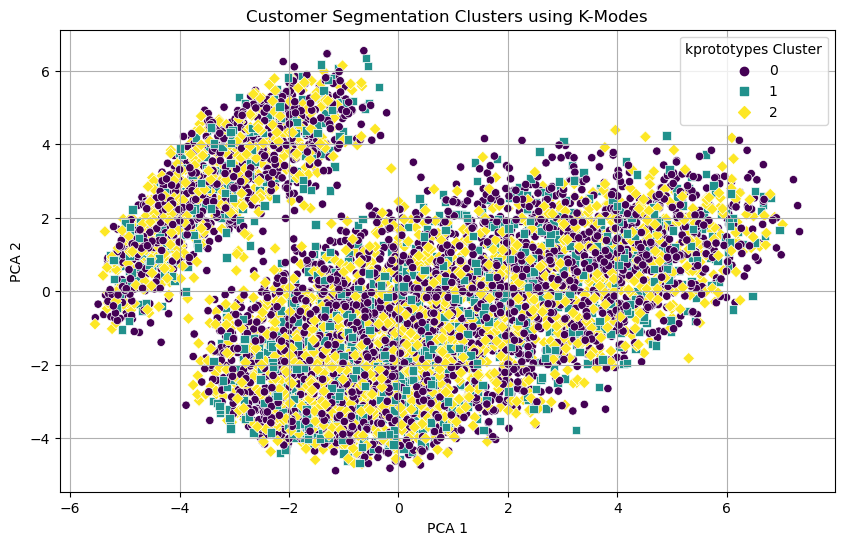

In [32]:
# Plotting K-Modes Clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(x='PCA1', y='PCA2', hue='Kmodes_cluster', data=pca_df, palette='viridis', style='Kmodes_cluster', markers=['o', 's', 'D'])
plt.title('Customer Segmentation Clusters using K-Modes')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.legend(title='kprototypes Cluster')
plt.grid()
plt.show()

# Kmeans Model

In [33]:
df_model = df_model.drop('Kmodes_cluster', axis=1)

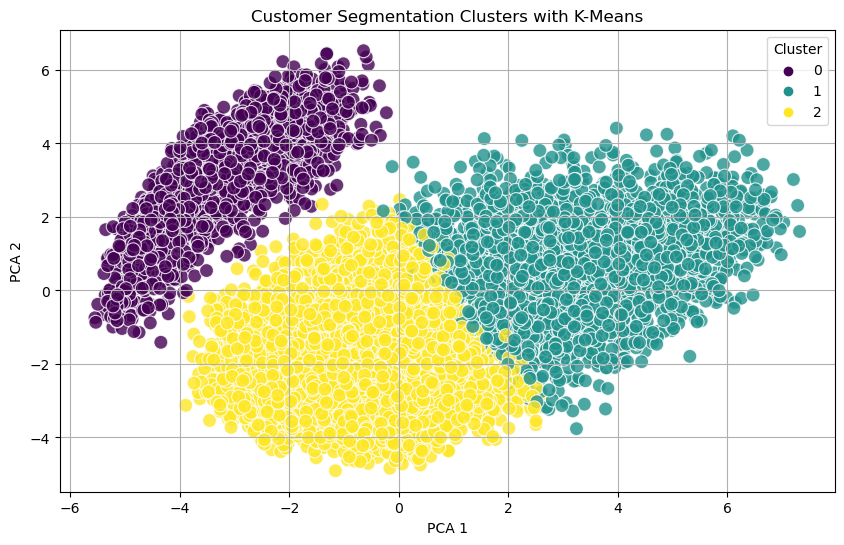

In [34]:
optimal_k = 3
kmeans = KMeans(n_clusters = optimal_k, random_state=42)
clusters = kmeans.fit_predict(scaled_data)

# Add cluster labels to the dataset
df_model['Kmeans_Cluster'] = clusters

# Apply PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(scaled_data)

# Create a DataFrame for PCA results
pca_df = pd.DataFrame(data=pca_result, columns=['PCA1', 'PCA2'])
pca_df['Kmeans_Cluster'] = df_model['Kmeans_Cluster']

# Plotting the clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(x='PCA1', y='PCA2', hue='Kmeans_Cluster', data=pca_df, palette='viridis', s=100, alpha=0.8)
plt.title('Customer Segmentation Clusters with K-Means')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.legend(title='Cluster')
plt.grid(True)
plt.show()

In [35]:
df_model.columns

Index(['SatisfactionScore', 'CLTV', 'MonthlyCharge', 'TotalCharges', 'TotalRefunds', 'TotalExtraDataCharges', 'TotalLongDistanceCharges', 'TotalRevenue', 'AvgMonthlyGBDownload', 'AvgMonthlyLongDistanceCharges', 'Gender', 'Age', 'Under30', 'SeniorCitizen', 'Married', 'Dependents', 'NumberOfDependents', 'Population', 'ReferredAFriend', 'NumberOfReferrals', 'TenureInMonths', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtectionPlan',
       'PremiumTechSupport', 'StreamingTV', 'StreamingMovies', 'StreamingMusic', 'UnlimitedData', 'PaperlessBilling', 'ChurnValue', 'Offer_None', 'Offer_Offer A', 'Offer_Offer B', 'Offer_Offer C', 'Offer_Offer D', 'Offer_Offer E', 'InternetType_Cable', 'InternetType_DSL', 'InternetType_Fiber Optic', 'InternetType_None', 'Contract_Month-to-Month', 'Contract_One Year', 'Contract_Two Year', 'PaymentMethod_Bank Withdrawal', 'PaymentMethod_Credit Card', 'PaymentMethod_Mailed Check',
       'Kmeans_Cluster'],
      

# Pen Portrait

In [36]:
df_model.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 51 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   SatisfactionScore              7043 non-null   int64  
 1   CLTV                           7043 non-null   int64  
 2   MonthlyCharge                  7043 non-null   float64
 3   TotalCharges                   7043 non-null   float64
 4   TotalRefunds                   7043 non-null   float64
 5   TotalExtraDataCharges          7043 non-null   float64
 6   TotalLongDistanceCharges       7043 non-null   float64
 7   TotalRevenue                   7043 non-null   float64
 8   AvgMonthlyGBDownload           7043 non-null   int64  
 9   AvgMonthlyLongDistanceCharges  7043 non-null   float64
 10  Gender                         7043 non-null   int32  
 11  Age                            7043 non-null   int64  
 12  Under30                        7043 non-null   i

In [37]:
data['kmeans_cluster'] = df_model['Kmeans_Cluster']

# Cluster 0

In [39]:
print('Total Number of Customers in Cluster 0:', data[data['kmeans_cluster']==0]['SeniorCitizen'].count())
print('Average Customer LifeTime Value:', data[data['kmeans_cluster']==0]['CLTV'].mean())
print('Average Customer Satisfaction Score:',data[data['kmeans_cluster']==0]['SatisfactionScore'].mean())
print('Average Total Revenue from Cluster 0:', data[data['kmeans_cluster']==0]['TotalRevenue'].mean())
print('Average Customer Tenure:', data[data['kmeans_cluster']==0]['TenureInMonths'].mean())
print('Average Total Long Distance Charges:', data[data['kmeans_cluster']==0]['TotalLongDistanceCharges'].mean())
print('Average Total Extra Data Charges:', data[data['kmeans_cluster']==0]['TotalExtraDataCharges'].mean())
print('Average Total Refunds:', data[data['kmeans_cluster']==0]['TotalRefunds'].mean())
print('Average Avg Mothly Gb Downloads:', data[data['kmeans_cluster']==0]['AvgMonthlyGBDownload'].mean())
print('Average Monthly Charges:', data[data['kmeans_cluster']==0]['MonthlyCharge'].mean())
print('Average No of Dependents:',data[data['kmeans_cluster']==0]['Dependents'].mean())
print('Average Age:',data[data['kmeans_cluster']==0]['Age'].mean())
print('No of Senior Citizens:',data[data['kmeans_cluster']==0]['SeniorCitizen'].value_counts())
print('No of People who Referred a Friend:',data[data['kmeans_cluster']==0]['ReferredAFriend'].value_counts())
print('Contract Type:',data[data['kmeans_cluster']==0]['Contract'].value_counts())
print('Relationship Status:',data[data['kmeans_cluster']==0]['Married'].value_counts())
print('Choice of Payment:',data[data['kmeans_cluster']==0]['PaymentMethod'].value_counts())
print('If they required tech support:',data[data['kmeans_cluster']==0]['PremiumTechSupport'].value_counts())
print('Choice of Internet service:',data[data['kmeans_cluster']==0]['InternetService'].value_counts())

Total Number of Customers in Cluster 0: 1527
Average Customer LifeTime Value: 4375.282252783235
Average Customer Satisfaction Score: 3.8500327439423705
Average Total Revenue from Cluster 0: 1431.8951277013755
Average Customer Tenure: 30.578912901113295
Average Total Long Distance Charges: 769.8447216764899
Average Total Extra Data Charges: 0.07858546168958742
Average Total Refunds: 1.6528618205631957
Average Avg Mothly Gb Downloads: 0.008513425016371971
Average Monthly Charges: 21.098199083169614
Average No of Dependents: 0.3693516699410609
Average Age: 42.777996070726914
No of Senior Citizens: SeniorCitizen
0    1475
1      52
Name: count, dtype: int64
No of People who Referred a Friend: ReferredAFriend
0    832
1    695
Name: count, dtype: int64
Contract Type: Contract
Two Year          642
Month-to-Month    519
One Year          366
Name: count, dtype: int64
Relationship Status: Married
0    788
1    739
Name: count, dtype: int64
Choice of Payment: PaymentMethod
Credit Card        9

# Cluster 1

In [40]:
print('Total Number of Customers in Cluster 1:', data[data['kmeans_cluster']==1]['SeniorCitizen'].count())
print('Average Customer LifeTime Value:', data[data['kmeans_cluster']==1]['CLTV'].mean())
print('Average Customer Satisfaction Score:', data[data['kmeans_cluster']==1]['SatisfactionScore'].mean())
print('Average Total Revenue from Cluster 1:', data[data['kmeans_cluster']==1]['TotalRevenue'].mean())
print('Average Customer Tenure:', data[data['kmeans_cluster']==1]['TenureInMonths'].mean())
print('Average Total Long Distance Charges:', data[data['kmeans_cluster']==1]['TotalLongDistanceCharges'].mean())
print('Average Total Extra Data Charges:', data[data['kmeans_cluster']==1]['TotalExtraDataCharges'].mean())
print('Average Total Refunds:', data[data['kmeans_cluster']==1]['TotalRefunds'].mean())
print('Average Avg Monthly GB Downloads:', data[data['kmeans_cluster']==1]['AvgMonthlyGBDownload'].mean())
print('Average Monthly Charges:', data[data['kmeans_cluster']==1]['MonthlyCharge'].mean())
print('Average No of Dependents:', data[data['kmeans_cluster']==1]['Dependents'].mean())
print('Average Age:', data[data['kmeans_cluster']==1]['Age'].mean())
print('No of Senior Citizens:', data[data['kmeans_cluster']==1]['SeniorCitizen'].value_counts())
print('No of People who Referred a Friend:', data[data['kmeans_cluster']==1]['ReferredAFriend'].value_counts())
print('Contract Type:', data[data['kmeans_cluster']==1]['Contract'].value_counts())
print('Relationship Status:', data[data['kmeans_cluster']==1]['Married'].value_counts())
print('Choice of Payment:', data[data['kmeans_cluster']==1]['PaymentMethod'].value_counts())
print('If they required tech support:', data[data['kmeans_cluster']==1]['PremiumTechSupport'].value_counts())
print('Choice of Internet service:', data[data['kmeans_cluster']==1]['InternetService'].value_counts())

Total Number of Customers in Cluster 1: 2320
Average Customer LifeTime Value: 4924.856896551724
Average Customer Satisfaction Score: 3.4357758620689656
Average Total Revenue from Cluster 1: 6388.789418103448
Average Customer Tenure: 56.533189655172414
Average Total Long Distance Charges: 1372.5766422413794
Average Total Extra Data Charges: 11.422413793103448
Average Total Refunds: 2.3698534482758618
Average Avg Monthly GB Downloads: 27.626293103448276
Average Monthly Charges: 88.26780172413793
Average No of Dependents: 0.27456896551724136
Average Age: 47.161637931034484
No of Senior Citizens: SeniorCitizen
0    1865
1     455
Name: count, dtype: int64
No of People who Referred a Friend: ReferredAFriend
1    1608
0     712
Name: count, dtype: int64
Contract Type: Contract
Two Year          1059
One Year           848
Month-to-Month     413
Name: count, dtype: int64
Relationship Status: Married
1    1683
0     637
Name: count, dtype: int64
Choice of Payment: PaymentMethod
Bank Withdrawal

# Cluster 2

In [41]:
print('Total Number of Customers in Cluster 2:', data[data['kmeans_cluster']==2]['SeniorCitizen'].count())
print('Average Customer LifeTime Value:', data[data['kmeans_cluster']==2]['CLTV'].mean())
print('Average Customer Satisfaction Score:', data[data['kmeans_cluster']==2]['SatisfactionScore'].mean())
print('Average Total Revenue from Cluster 2:', data[data['kmeans_cluster']==2]['TotalRevenue'].mean())
print('Average Customer Tenure:', data[data['kmeans_cluster']==2]['TenureInMonths'].mean())
print('Average Total Long Distance Charges:', data[data['kmeans_cluster']==2]['TotalLongDistanceCharges'].mean())
print('Average Total Extra Data Charges:', data[data['kmeans_cluster']==2]['TotalExtraDataCharges'].mean())
print('Average Total Refunds:', data[data['kmeans_cluster']==2]['TotalRefunds'].mean())
print('Average Avg Monthly GB Downloads:', data[data['kmeans_cluster']==2]['AvgMonthlyGBDownload'].mean())
print('Average Monthly Charges:', data[data['kmeans_cluster']==2]['MonthlyCharge'].mean())
print('Average No of Dependents:', data[data['kmeans_cluster']==2]['Dependents'].mean())
print('Average Age:', data[data['kmeans_cluster']==2]['Age'].mean())
print('No of Senior Citizens:', data[data['kmeans_cluster']==2]['SeniorCitizen'].value_counts())
print('No of People who Referred a Friend:', data[data['kmeans_cluster']==2]['ReferredAFriend'].value_counts())
print('Contract Type:', data[data['kmeans_cluster']==2]['Contract'].value_counts())
print('Relationship Status:', data[data['kmeans_cluster']==2]['Married'].value_counts())
print('Choice of Payment:', data[data['kmeans_cluster']==2]['PaymentMethod'].value_counts())
print('If they required tech support:', data[data['kmeans_cluster']==2]['PremiumTechSupport'].value_counts())
print('Choice of Internet service:', data[data['kmeans_cluster']==2]['InternetService'].value_counts())

Total Number of Customers in Cluster 2: 3196
Average Customer LifeTime Value: 4031.4640175219024
Average Customer Satisfaction Score: 2.8172715894868587
Average Total Revenue from Cluster 2: 1365.030156445557
Average Customer Tenure: 15.722465581977472
Average Total Long Distance Charges: 286.600563204005
Average Total Extra Data Charges: 6.78973717146433
Average Total Refunds: 1.8140394242803504
Average Avg Monthly GB Downloads: 25.151439299123904
Average Monthly Charges: 68.5601846057572
Average No of Dependents: 0.1332916145181477
Average Age: 47.81946182728411
No of Senior Citizens: SeniorCitizen
0    2561
1     635
Name: count, dtype: int64
No of People who Referred a Friend: ReferredAFriend
0    2277
1     919
Name: count, dtype: int64
Contract Type: Contract
Month-to-Month    2678
One Year           336
Two Year           182
Name: count, dtype: int64
Relationship Status: Married
0    2216
1     980
Name: count, dtype: int64
Choice of Payment: PaymentMethod
Bank Withdrawal    20

# Pen Portrait

# Pen Portrait (Kmeans Cluster)

Cluster 0: The Loyal Bundlers
Characteristics:

Customer Count: 2,256
Lifetime Value: High ($4,931)
Satisfaction: Moderate (3.43/5)
Tenure: Long (57 months)
Monthly Charges: High ($89.31)
Demographics: Mature customers, average age 46.9, with 19% being senior citizens.
Dependents: Few (0.28 on average).
Referral Status: 70% referred a friend.
Contract Type: Two-Year (45%), One-Year (34%), Month-to-Month (21%).
Payment Preferences: Bank Withdrawal (61%), Credit Card (38%), Mailed Checks (1%).
Tech Support: 58% use premium support.
Internet Service: All customers subscribe.
Pen Portrait:
Cluster 0 represents loyal, long-term customers who are engaged with the company's services. They are cost-aware but maintain high-value contracts. They value stability and consistently refer friends, indicating satisfaction. Most use bank withdrawals and benefit from internet services, though their satisfaction could be improved.

Profitability Improvement Strategies:

Reward Long-Term Loyalty: Offer exclusive rewards, discounts, or tiered loyalty perks to Two-Year and One-Year contract customers.
Upsell Premium Features: Target non-premium tech support users with discounts for bundled packages.
Referral Programs: Encourage more referrals by offering dual-sided incentives.
Satisfaction Surveys: Focus on feedback from this cluster to identify small service tweaks to boost satisfaction.


Cluster 1: The Frugal Tech-Free Cohort
    
Characteristics:

Customer Count: 1,528
Lifetime Value: Moderate ($4,376)
Satisfaction: High (3.85/5)
Tenure: Moderate (31 months)
Monthly Charges: Low ($21.11)
Demographics: Younger (average age 42.8), mostly non-senior citizens.
Dependents: Some (0.37 on average).
Referral Status: 54% have not referred a friend.
Contract Type: Two-Year (42%), Month-to-Month (34%), One-Year (24%).
Payment Preferences: Credit Card (61%), Bank Withdrawal (30%), Mailed Checks (9%).
Tech Support: None use premium support.
Internet Service: Predominantly no internet service.

Pen Portrait:

Cluster 1 

includes frugal customers who prefer low-cost, limited services. Their high satisfaction comes from minimal expectations, and they favor contracts with moderate commitment. Their lack of tech and internet service use suggests a low-tech lifestyle or competing providers.

Profitability Improvement Strategies:

Introduce Value Add-Ons: Offer affordable, entry-level internet or tech support services.
    
Reward Contract Upgrades: Incentivize Month-to-Month users to commit to One-Year or Two-Year plans.
    
Engage with Cross-Selling: Leverage their satisfaction to cross-sell affordable packages for other services.
    
Digital Literacy Campaigns: Educate this group on the benefits of internet and tech services.


Cluster 2:
    
The Budget-Conscious Explorers

Characteristics:

Customer Count: 3,259
Lifetime Value: Low ($4,044)
Satisfaction: Low (2.84/5)
Tenure: Short (16 months)
Monthly Charges: Moderate ($68.24)
Demographics: Older (average age 48), with 20% being senior citizens.
Dependents: Few (0.13 on average).
Referral Status: 71% did not refer a friend.
Contract Type: Month-to-Month (81%), One-Year (12%), Two-Year (7%).
Payment Preferences: Bank Withdrawal (64%), Credit Card (30%), Mailed Checks (6%).
Tech Support: Mostly avoid premium support (77%).
Internet Service: All customers subscribe.
Pen Portrait:
    
Cluster 2

includes short-tenure, budget-conscious customers who are still exploring the company’s offerings. Their dissatisfaction and lack of referrals indicate a need for improved engagement. They value flexibility, as most prefer Month-to-Month contracts.

Profitability Improvement Strategies:

Targeted Retention Offers: Provide discounts or bonuses to encourage them to switch to longer-term contracts.
Improved Onboarding Experience: Implement initiatives to enhance their satisfaction during the initial months of service.
Feedback-Driven Customization: Offer customizable packages to align better with their needs.
Digital Engagement Campaigns: Leverage their internet usage to offer value-added services, such as faster internet or entertainment bundles.any refinements to this profile? 🚀

# Survival Analysis

In [42]:
# Import Libraries
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter

In [43]:
data.head()

,SatisfactionScore,CLTV,MonthlyCharge,TotalCharges,TotalRefunds,TotalExtraDataCharges,TotalLongDistanceCharges,TotalRevenue,AvgMonthlyGBDownload,AvgMonthlyLongDistanceCharges,Gender,Age,Under30,SeniorCitizen,Married,Dependents,NumberOfDependents,Population,ReferredAFriend,NumberOfReferrals,TenureInMonths,Offer,PhoneService,MultipleLines,InternetService,InternetType,OnlineSecurity,OnlineBackup,DeviceProtectionPlan,PremiumTechSupport,StreamingTV,StreamingMovies,StreamingMusic,UnlimitedData,Contract,PaperlessBilling,PaymentMethod,ChurnValue,kmeans_cluster
0,3,5798,110.05,7430.75,23.16,0.0,393.99,7801.58,73,5.71,1,27,1,0,0,0,0,40270,0,0,69,Offer A,Yes,Yes,Yes,Fiber Optic,Yes,Yes,Yes,No,Yes,Yes,Yes,Yes,Two Year,Yes,Credit Card,0,1
1,1,4580,76.65,333.60,0.00,0.0,96.36,429.96,17,24.09,0,36,0,0,0,0,0,404,0,0,4,None,Yes,No,Yes,Fiber Optic,No,Yes,No,No,No,No,No,Yes,Month-to-Month,Yes,Bank Withdrawal,1,2
2,4,4072,79.20,5420.65,0.00,0.0,1487.64,6908.29,17,21.56,1,53,0,0,1,1,1,18036,1,5,69,Offer A,Yes,Yes,Yes,Fiber Optic,No,No,Yes,No,No,No,No,Yes,Two Year,Yes,Credit Card,0,1
3,1,4981,85.60,1345.55,0.00,0.0,678.75,2024.30,22,45.25,1,74,0,1,1,0,0,261,1,1,15,None,Yes,Yes,Yes,Cable,No,No,No,No,No,Yes,No,Yes,Month-to-Month,Yes,Bank Withdrawal,1,2
4,3,3372,19.65,225.75,0.00,0.0,448.36,674.11,0,40.76,1,48,0,0,1,1,2,12083,1,2,11,Offer D,Yes,No,No,None,No,No,No,No,No,No,No,No,Two Year,No,Credit Card,0,0


Text(0, 0.5, 'Survival probability')

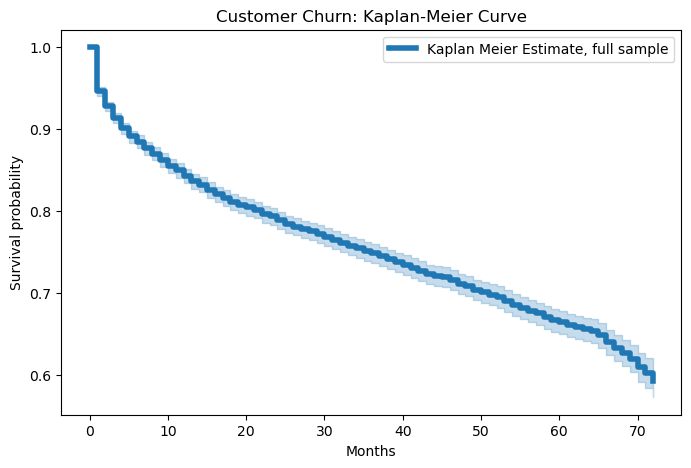

In [44]:
#Kaplan meier plot
kmf = KaplanMeierFitter()

kmf.fit(data['TenureInMonths'], data['ChurnValue'], label = 'Kaplan Meier Estimate, full sample')

kmf.plot(linewidth=4, figsize=(8, 5))
plt.title('Customer Churn: Kaplan-Meier Curve')
plt.xlabel('Months')
plt.ylabel('Survival probability')

# Survival Analysis Based on Contract length















In [45]:
data['PaymentMethod'].unique()

array(['Credit Card', 'Bank Withdrawal', 'Mailed Check'], dtype=object)

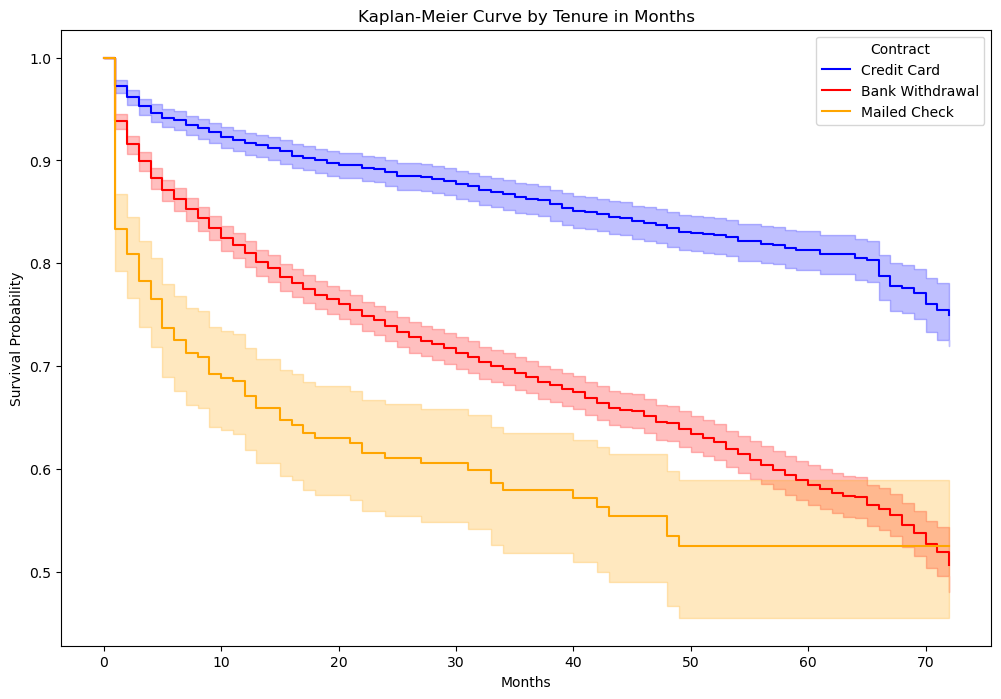

In [46]:
# Instantiate the Kaplan-Meier Fitter model
kmf = KaplanMeierFitter()

# Get a list of unique product categories
categories = data['PaymentMethod'].unique()

# Define a color palette (ensure it has enough colors for each category)
colors = ['blue', 'red', 'orange']

# Create a figure for the plots
plt.figure(figsize=(12, 8))

# Loop through each product category with a color for each category
for i, category in enumerate(categories):
    # Filter the data for the current category
    df_new = data[data['PaymentMethod'] == category]
    
    # Fit the Kaplan-Meier model on 'Tenure in Months' and 'Churn Value'
    kmf.fit(df_new['TenureInMonths'], df_new['ChurnValue'])
    
    # Plot the survival curve for the current category with a specific color
    kmf.plot(label=category, color=colors[i % len(colors)])
    
# Add title and labels to the plot
plt.title('Kaplan-Meier Curve by Tenure in Months')
plt.xlabel('Months')
plt.ylabel('Survival Probability')

# Show the legend for each category
plt.legend(title='Contract')

# Display the plot
plt.show()

In [47]:
data.head()

,SatisfactionScore,CLTV,MonthlyCharge,TotalCharges,TotalRefunds,TotalExtraDataCharges,TotalLongDistanceCharges,TotalRevenue,AvgMonthlyGBDownload,AvgMonthlyLongDistanceCharges,Gender,Age,Under30,SeniorCitizen,Married,Dependents,NumberOfDependents,Population,ReferredAFriend,NumberOfReferrals,TenureInMonths,Offer,PhoneService,MultipleLines,InternetService,InternetType,OnlineSecurity,OnlineBackup,DeviceProtectionPlan,PremiumTechSupport,StreamingTV,StreamingMovies,StreamingMusic,UnlimitedData,Contract,PaperlessBilling,PaymentMethod,ChurnValue,kmeans_cluster
0,3,5798,110.05,7430.75,23.16,0.0,393.99,7801.58,73,5.71,1,27,1,0,0,0,0,40270,0,0,69,Offer A,Yes,Yes,Yes,Fiber Optic,Yes,Yes,Yes,No,Yes,Yes,Yes,Yes,Two Year,Yes,Credit Card,0,1
1,1,4580,76.65,333.60,0.00,0.0,96.36,429.96,17,24.09,0,36,0,0,0,0,0,404,0,0,4,None,Yes,No,Yes,Fiber Optic,No,Yes,No,No,No,No,No,Yes,Month-to-Month,Yes,Bank Withdrawal,1,2
2,4,4072,79.20,5420.65,0.00,0.0,1487.64,6908.29,17,21.56,1,53,0,0,1,1,1,18036,1,5,69,Offer A,Yes,Yes,Yes,Fiber Optic,No,No,Yes,No,No,No,No,Yes,Two Year,Yes,Credit Card,0,1
3,1,4981,85.60,1345.55,0.00,0.0,678.75,2024.30,22,45.25,1,74,0,1,1,0,0,261,1,1,15,None,Yes,Yes,Yes,Cable,No,No,No,No,No,Yes,No,Yes,Month-to-Month,Yes,Bank Withdrawal,1,2
4,3,3372,19.65,225.75,0.00,0.0,448.36,674.11,0,40.76,1,48,0,0,1,1,2,12083,1,2,11,Offer D,Yes,No,No,None,No,No,No,No,No,No,No,No,Two Year,No,Credit Card,0,0


# Cox Regression

In [48]:
data.columns

Index(['SatisfactionScore', 'CLTV', 'MonthlyCharge', 'TotalCharges', 'TotalRefunds', 'TotalExtraDataCharges', 'TotalLongDistanceCharges', 'TotalRevenue', 'AvgMonthlyGBDownload', 'AvgMonthlyLongDistanceCharges', 'Gender', 'Age', 'Under30', 'SeniorCitizen', 'Married', 'Dependents', 'NumberOfDependents', 'Population', 'ReferredAFriend', 'NumberOfReferrals', 'TenureInMonths', 'Offer', 'PhoneService', 'MultipleLines', 'InternetService', 'InternetType', 'OnlineSecurity', 'OnlineBackup',
       'DeviceProtectionPlan', 'PremiumTechSupport', 'StreamingTV', 'StreamingMovies', 'StreamingMusic', 'UnlimitedData', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'ChurnValue', 'kmeans_cluster'],
      dtype='object')

In [49]:
# Select Appropriate Columns (columns which we can use to)
df_cox = data[['Population','SeniorCitizen', 'NumberOfDependents', 
 'InternetService', 'Contract', 'PaperlessBilling', 'PremiumTechSupport', 'Under30',
 'MonthlyCharge', 'Age', 'Married','TenureInMonths', 'AvgMonthlyLongDistanceCharges', 
 'AvgMonthlyGBDownload', 'UnlimitedData', 'TotalExtraDataCharges', 'SatisfactionScore', 'ChurnValue'
 ]]

In [50]:
df_cox.head()

,Population,SeniorCitizen,NumberOfDependents,InternetService,Contract,PaperlessBilling,PremiumTechSupport,Under30,MonthlyCharge,Age,Married,TenureInMonths,AvgMonthlyLongDistanceCharges,AvgMonthlyGBDownload,UnlimitedData,TotalExtraDataCharges,SatisfactionScore,ChurnValue
0,40270,0,0,Yes,Two Year,Yes,No,1,110.05,27,0,69,5.71,73,Yes,0.0,3,0
1,404,0,0,Yes,Month-to-Month,Yes,No,0,76.65,36,0,4,24.09,17,Yes,0.0,1,1
2,18036,0,1,Yes,Two Year,Yes,No,0,79.20,53,1,69,21.56,17,Yes,0.0,4,0
3,261,1,0,Yes,Month-to-Month,Yes,No,0,85.60,74,1,15,45.25,22,Yes,0.0,1,1
4,12083,0,2,No,Two Year,No,No,0,19.65,48,1,11,40.76,0,No,0.0,3,0


In [51]:
df_cox.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 18 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Population                     7043 non-null   int64  
 1   SeniorCitizen                  7043 non-null   int32  
 2   NumberOfDependents             7043 non-null   int64  
 3   InternetService                7043 non-null   object 
 4   Contract                       7043 non-null   object 
 5   PaperlessBilling               7043 non-null   object 
 6   PremiumTechSupport             7043 non-null   object 
 7   Under30                        7043 non-null   int32  
 8   MonthlyCharge                  7043 non-null   float64
 9   Age                            7043 non-null   int64  
 10  Married                        7043 non-null   int32  
 11  TenureInMonths                 7043 non-null   int64  
 12  AvgMonthlyLongDistanceCharges  7043 non-null   f

Encode Columns with 2 categories

In [53]:
print(df_cox.head())


   Population  SeniorCitizen  NumberOfDependents InternetService        Contract PaperlessBilling PremiumTechSupport  Under30  MonthlyCharge  Age  Married  TenureInMonths  AvgMonthlyLongDistanceCharges  AvgMonthlyGBDownload UnlimitedData  TotalExtraDataCharges  SatisfactionScore ChurnValue
0       40270              0                   0             Yes        Two Year              Yes                 No        1         110.05   27        0              69                           5.71                    73           Yes                    0.0                  3          0
1         404              0                   0             Yes  Month-to-Month              Yes                 No        0          76.65   36        0               4                          24.09                    17           Yes                    0.0                  1          1
2       18036              0                   1             Yes        Two Year              Yes                 No        0  

In [55]:
df_cox['SeniorCitizen'] = pd.get_dummies(df_cox['SeniorCitizen'], drop_first=True, dtype = 'int')
df_cox['PremiumTechSupport'] = pd.get_dummies(df_cox['PremiumTechSupport'], drop_first=True, dtype = 'int')
df_cox['Married'] = pd.get_dummies(df_cox['Married'], drop_first=True, dtype = 'int')
df_cox['UnlimitedData'] = pd.get_dummies(df_cox['UnlimitedData'], drop_first=True, dtype = 'int')
df_cox['PaperlessBilling'] = pd.get_dummies(df_cox['PaperlessBilling'], drop_first=True, dtype = 'int')

In [56]:
df_cox['InternetService'] = pd.get_dummies(df_cox['InternetService'], drop_first=True, dtype = 'int')

In [57]:
df_cox['ChurnValue'] = pd.get_dummies(df_cox['ChurnValue'],drop_first=True,dtype='int')

# Enocding Columns with more than 2 categories

In [58]:
contract = pd.get_dummies(df_cox['Contract'], drop_first=True,dtype = 'int')
df_cox = pd.concat([df_cox,contract],axis=1)
df_cox = df_cox.drop('Contract',axis=1)

In [59]:
df_cox.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 19 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Population                     7043 non-null   int64  
 1   SeniorCitizen                  7043 non-null   int32  
 2   NumberOfDependents             7043 non-null   int64  
 3   InternetService                7043 non-null   int32  
 4   PaperlessBilling               7043 non-null   int32  
 5   PremiumTechSupport             7043 non-null   int32  
 6   Under30                        7043 non-null   int32  
 7   MonthlyCharge                  7043 non-null   float64
 8   Age                            7043 non-null   int64  
 9   Married                        7043 non-null   int32  
 10  TenureInMonths                 7043 non-null   int64  
 11  AvgMonthlyLongDistanceCharges  7043 non-null   float64
 12  AvgMonthlyGBDownload           7043 non-null   i

In [60]:
cph = CoxPHFitter()
cph.fit(df_cox, duration_col='TenureInMonths',event_col='ChurnValue')
cph.print_summary(style='ascii')

<lifelines.CoxPHFitter: fitted with 7043 total observations, 5174 right-censored observations>
             duration col = 'TenureInMonths'
                event col = 'ChurnValue'
      baseline estimation = breslow
   number of observations = 7043
number of events observed = 1869
   partial log-likelihood = -12890.46
         time fit was run = 2025-02-17 15:00:26 UTC

---
                               coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                                      
Population                     0.00      1.00      0.00            0.00            0.00                1.00                1.00
SeniorCitizen                 -0.21      0.81      0.09           -0.39           -0.02                0.68                0.98
NumberOfDependents            -0.27      0.76      0.05           -0.37           -0.18                0.69   

This Cox Proportional Hazards model output provides insights into the factors affecting customer churn based on survival analysis. Here’s a breakdown of the key findings:

1. Model Summary
Number of Observations: 7,043 customers
Right-Censored Observations: 5,174 (customers who haven't churned)
Events (Churns): 1,869 (customers who have churned)
Baseline Estimation: Breslow method
Concordance Score: 0.92, indicating the model has excellent predictive power.
Log-likelihood Ratio Test: 5528.61 (p < 0.005), meaning the model is statistically significant.


2. Key Factors Affecting Churn
The coef (log hazard ratio) indicates how each variable affects churn risk:

Positive coef → Higher risk of churn
Negative coef → Lower risk of churn
exp(coef) (Hazard Ratio, HR) helps interpret risk:
HR > 1: Increases churn risk.
HR < 1: Reduces churn risk.
Significant Factors Increasing Churn Risk (HR > 1)
InternetService (HR = 2.15, p < 0.005)
Customers with internet service are 2.15 times more likely to churn than those without.
AvgMonthlyLongDistanceCharges (HR = 1.00, p = 0.01)
A small but significant increase in churn for customers with high long-distance charges.
Significant Factors Reducing Churn Risk (HR < 1)
One-Year Contract (HR = 0.21, p < 0.005)
Customers with a one-year contract are 79% less likely to churn.
Two-Year Contract (HR = 0.03, p < 0.005)
Customers with a two-year contract are 97% less likely to churn.
SatisfactionScore (HR = 0.37, p < 0.005)
Higher satisfaction strongly reduces churn risk.
Married Customers (HR = 0.59, p < 0.005)
Married customers have 41% lower churn risk.
PremiumTechSupport (HR = 0.77, p < 0.005)
Customers with premium tech support are 23% less likely to churn.
UnlimitedData (HR = 0.69, p < 0.005)
Customers with unlimited data are 31% less likely to churn.
NumberOfDependents (HR = 0.76, p < 0.005)
Customers with more dependents are 24% less likely to churn.
SeniorCitizen (HR = 0.81, p = 0.03)
Older customers are 19% less likely to churn.
MonthlyCharge (HR = 0.99, p < 0.005)
Higher monthly charges slightly reduce churn.
Non-Significant Factors (p > 0.05)
PaperlessBilling (p = 0.77)
Under30 (p = 0.82)
Age (p = 0.25)
AvgMonthlyGBDownload (p = 0.83)
These factors do not significantly impact churn in this model.



3. Business Implications
Contract Length is Critical

Customers with one-year or two-year contracts churn significantly less.
Offering incentives to sign long-term contracts could reduce churn.
Customer Satisfaction is Key

Lower satisfaction strongly increases churn (largest impact).
Investing in customer service and issue resolution is essential.
Premium Tech Support & Unlimited Data Help Retain Customers

These reduce churn, so bundling them in packages could improve retention.
Internet Services & Long-Distance Charges Increase Churn

Customers using internet services and long-distance calling are more likely to churn.
Consider offering discounts or better service options.
Married & Senior Customers Are More Loyal

They churn less, so they could be targeted with retention marketing efforts.


3. Business Implications
Contract Length is Critical

Customers with one-year or two-year contracts churn significantly less.
Offering incentives to sign long-term contracts could reduce churn.
Customer Satisfaction is Key

Lower satisfaction strongly increases churn (largest impact).
Investing in customer service and issue resolution is essential.
Premium Tech Support & Unlimited Data Help Retain Customers

These reduce churn, so bundling them in packages could improve retention.
Internet Services & Long-Distance Charges Increase Churn

Customers using internet services and long-distance calling are more likely to churn.
Consider offering discounts or better service options.
Married & Senior Customers Are More Loyal

They churn less, so they could be targeted with retention marketing efforts.


Here are some key actionable insights from your Cox Proportional Hazards Model results for customer churn prediction:

1. Customer Segments Less Likely to Churn (Retention Strategies)

Customers with a one-year or two-year contract are significantly less likely to churn compared to those on month-to-month plans.

✅ Action: Encourage month-to-month customers to switch to longer contracts with discounts or perks.
Married customers and those with dependents have a lower risk of churn.

✅ Action: Create family-oriented bundles or promotions to attract and retain these segments.
Customers with premium tech support are less likely to leave.

✅ Action: Promote premium support services as an add-on to increase customer stickiness.
Customers with unlimited data plans are less likely to churn.

✅ Action: Offer affordable unlimited data plans or bonuses to encourage more sign-ups.
Higher satisfaction scores are strongly associated with lower churn rates.

✅ Action: Continuously track satisfaction scores and proactively engage dissatisfied customers before they churn.
2. Customer Segments More Likely to Churn (Risk Mitigation)
Customers using Internet Service have more than twice the risk of churn (exp(coef) = 2.15)
.
✅ Action: Investigate complaints about internet quality, speed, or pricing, and improve service reliability.
Customers with higher Monthly Charges are slightly more likely to churn.

✅ Action: Offer loyalty discounts, bundling options, or flexible payment plans to high-paying customers.
Senior citizens have a higher likelihood of churn.

✅ Action: Create tailored services or discounts for older customers, such as easy billing methods or senior-friendly customer support.
Paperless billing has no significant effect on churn.

✅ Action: Focus retention efforts elsewhere rather than promoting paperless billing as a loyalty strategy.

3. Key Pricing and Service Adjustments
Higher total extra data charges are slightly associated with higher churn.

✅ Action: Consider offering data rollover or reducing extra data charges to prevent frustration.
Avg Monthly Long-Distance Charges are slightly associated with churn.

✅ Action: If applicable, introduce better long-distance call packages to make the service more attractive.

4. Churn Prediction & Proactive Intervention
Concordance Score = 0.92 → The model is highly predictive, meaning it effectively differentiates between customers likely to churn and those who will stay.

✅ Action: Use this model to score existing customers and proactively reach out to those with high churn risk (e.g., offering incentives, conducting personalized engagement).

Final Recommendations:

Incentive long-term contracts (reduce month-to-month churn).
Improve internet service quality (to address the high churn rate among users).
Offer data and billing flexibility (reduce extra charges, improve pricing plans).
Focus on customer satisfaction monitoring and proactive outreach.
Identify and engage at-risk segments early using the churn prediction model.


